<a href="https://colab.research.google.com/github/MarigoldJ/ygl2/blob/main/class/20210617_nlp_day6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Today's Topic

*  어제는 단어 단위, 오늘은 글자 단위로 모델에 넣어서 예측해볼 것!

# 글자 단위 RNN 언어 모델

![r](https://wikidocs.net/images/page/48649/char_rnn1.PNG)

In [1]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

In [2]:
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")

('11-0.txt', <http.client.HTTPMessage at 0x7f1e5d9f9f10>)

In [3]:
f = open('11-0.txt', 'rb')
lines = []
for line in f:
    line = line.strip().lower().decode('ascii', 'ignore')
    if len(line) > 0:
        lines.append(line)
f.close()

In [4]:
lines[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [5]:
text = ' '.join(lines)
print('문자열의 길이 또는 총 글자의 개수 :', len(text))

문자열의 길이 또는 총 글자의 개수 : 159484


In [6]:
print(text[:10])

the projec


In [7]:
# 글자 집합을 만들어보자
char_vocab = sorted(list(set(text)))
vocab_size = len(char_vocab)
print('글자 집합의 크기 :', vocab_size)
print(char_vocab)

글자 집합의 크기 : 56
[' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
# 글자 집합에 인덱스를 부여하고 전부 출력하기
char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
print(char_to_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [9]:
# 인덱스로부터 글자를 리턴하기
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key
print(index_to_char)

{0: ' ', 1: '!', 2: '"', 3: '#', 4: '$', 5: '%', 6: "'", 7: '(', 8: ')', 9: '*', 10: ',', 11: '-', 12: '.', 13: '/', 14: '0', 15: '1', 16: '2', 17: '3', 18: '4', 19: '5', 20: '6', 21: '7', 22: '8', 23: '9', 24: ':', 25: ';', 26: '?', 27: '[', 28: ']', 29: '_', 30: 'a', 31: 'b', 32: 'c', 33: 'd', 34: 'e', 35: 'f', 36: 'g', 37: 'h', 38: 'i', 39: 'j', 40: 'k', 41: 'l', 42: 'm', 43: 'n', 44: 'o', 45: 'p', 46: 'q', 47: 'r', 48: 's', 49: 't', 50: 'u', 51: 'v', 52: 'w', 53: 'x', 54: 'y', 55: 'z'}


In [10]:
# 훈련데이터를 구성
# apple
# sample의 길이 4

# example) 샘플의 길이가 4라면 4개의 입력 글자 시퀀스로부터 4개의 출력 글자 시퀀스 예측. 즉 RNN의 time step은 4번
# appl -> pple
# appl : 입력시퀀스, train_x
# pple : 예측시퀀스, train_y


In [11]:
# 15만 8천의 길이를 가진 text 문자열로부터 다수의 문장 샘플들로 분리
# 분리하는 방법은 문장 샘플의 길이를 정하고, 해당 길이만큼 문자열 전부를 전부 등분하는 것!

seq_length = 60
n_samples = int(np.floor( (len(text)-1) / seq_length )) # 문자열을 60등분한다 --> 총 샘플의 수
print('문자 샘플의 수 :', n_samples)

문자 샘플의 수 : 2658


In [12]:
train_x = []
train_y = []

for i in range(n_samples):
    x_sample = text[i * seq_length: (i+1)*seq_length]       # 문장 샘플을 1개씩 가져옴
    x_encoded = [char_to_index[c] for c in x_sample]        # 하나의 문장 샘플에 대해 encoding
    train_x.append(x_encoded)

    y_sample = text[i*seq_length + 1: (i+1)*seq_length + 1] # x보다 한칸 오른쪽으로 shift
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [13]:
print(train_x[0])
print(train_y[0])

[49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]
[37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]


In [14]:
# x와 y에 대해 원-핫 인코딩 수행
# 입력시퀀스에 대해 워드 임베딩 하지 않습니다 (embedding layer 사용 X)
train_x = to_categorical(train_x)
train_y = to_categorical(train_y)

print('train_x의 크기 (shape) :', train_x.shape)    # (2658, 60, 56)
print('train_y의 크기 (shape) :', train_y.shape)    # (2658, 60, 56)

# 샘플의 수 : 2658
# 입력시퀀스 길이(input_length) : 60
# 각 벡터의 차원(input_dim) : 56


train_x의 크기 (shape) : (2658, 60, 56)
train_y의 크기 (shape) : (2658, 60, 56)


![](https://wikidocs.net/images/page/22886/rnn_image6between7.PNG)

## 모델 설계하기

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [16]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, train_x.shape[2]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=80, verbose=1)

Epoch 1/80
84/84 [==============================] - 6s 12ms/step - loss: 3.0811 - accuracy: 0.1801
Epoch 2/80
84/84 [==============================] - 1s 12ms/step - loss: 2.7441 - accuracy: 0.2436
Epoch 3/80
84/84 [==============================] - 1s 12ms/step - loss: 2.3913 - accuracy: 0.3291
Epoch 4/80
84/84 [==============================] - 1s 12ms/step - loss: 2.2314 - accuracy: 0.3674
Epoch 5/80
84/84 [==============================] - 1s 12ms/step - loss: 2.1205 - accuracy: 0.3925
Epoch 6/80
84/84 [==============================] - 1s 12ms/step - loss: 2.0284 - accuracy: 0.4161
Epoch 7/80
84/84 [==============================] - 1s 12ms/step - loss: 1.9524 - accuracy: 0.4370
Epoch 8/80
84/84 [==============================] - 1s 12ms/step - loss: 1.8891 - accuracy: 0.4530
Epoch 9/80
84/84 [==============================] - 1s 12ms/step - loss: 1.8332 - accuracy: 0.4680
Epoch 10/80
84/84 [==============================] - 1s 12ms/step - loss: 1.7790 - accuracy: 0.4840
Epoch 11/

In [28]:
def sentence_generation(model, length):

    ix = [np.random.randint(vocab_size)]        # 글자에 대한 랜덤 인덱스 생성
    y_char = [index_to_char[ix[-1]]]            # 랜덤 인덱스로부터 글자 생성
    print(ix[-1], '번 글자', y_char[-1], '로 예측을 시작!!')
    
    X = np.zeros((1, length, vocab_size))       # LSTM의 입력 시퀀스 생성

    for i in range(length):
        X[0][i][ix[-1]] = 1                     # 예측 글자를 다음 입력 시퀀스에 추가
        print(index_to_char[ix[-1]], end='')
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    
    return ('').join(y_char)



In [27]:
sentence_generation(model, 100)

0 번 글자   로 예측을 시작!!
 and then said the fourth. two days wrong! sighed the hatter. i dene read: it mest question is, you 

' and then said the fourth. two days wrong! sighed the hatter. i dene read: it mest question is, you d'

In [29]:
sentence_generation(model, 100)

41 번 글자 l 로 예측을 시작!!
ll her knowledge of history, alice had no very clear notion here! _you do not agree to abide a pie o

'll her knowledge of history, alice had no very clear notion here! _you do not agree to abide a pie of'

# 글자 단위 RNN(Char RNN)으로 텍스트 생성하기

* 다 대 일(many-to-one)구조의 RNN을 글자 단위로 학습시키고, 텍스트 생성하기

## 데이터에 대한 이해와 전처리

In [30]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [31]:
text='''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''


In [32]:
tokens = text.split()       # \n 제거
text = ' '.join(tokens)

print(text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [33]:
# 중복 제거한 글자 집합 생성
char_vocab = sorted(list(set(text)))

print(char_vocab)

[' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [34]:
# 글자 집합의 크기
vocab_size = len(char_vocab)

print('글자 집합의 크기 :', vocab_size)

글자 집합의 크기 : 33


In [37]:
# 글자에 고유한 정수 인덱스 부여
char_to_index = dict((c, i) for i, c in enumerate(char_vocab))

print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


* example 5개의 입력 글자 시퀀스로부터 다음 글자 시퀀스를 예측
    * stude -> n
    * tuden -> t

In [47]:
length = 11
sequences = []
for i in range(length, len(text)):
    seq = text[i-length:i]  # 길이 11의 문자열을 지속적으로 만듦
    sequences.append(seq)

print('총 훈련 샘플의 수 :', len(sequences))
print(sequences)

총 훈련 샘플의 수 : 426
['I get on wi', ' get on wit', 'get on with', 'et on with ', 't on with l', ' on with li', 'on with lif', 'n with life', ' with life ', 'with life a', 'ith life as', 'th life as ', 'h life as a', ' life as a ', 'life as a p', 'ife as a pr', 'fe as a pro', 'e as a prog', ' as a progr', 'as a progra', 's a program', ' a programm', 'a programme', ' programmer', 'programmer,', 'rogrammer, ', 'ogrammer, I', 'grammer, I ', 'rammer, I l', 'ammer, I li', 'mmer, I lik', 'mer, I like', 'er, I like ', 'r, I like t', ', I like to', ' I like to ', 'I like to c', ' like to co', 'like to con', 'ike to cont', 'ke to conte', 'e to contem', ' to contemp', 'to contempl', 'o contempla', ' contemplat', 'contemplate', 'ontemplate ', 'ntemplate b', 'template be', 'emplate bee', 'mplate beer', 'plate beer.', 'late beer. ', 'ate beer. B', 'te beer. Bu', 'e beer. But', ' beer. But ', 'beer. But w', 'eer. But wh', 'er. But whe', 'r. But when', '. But when ', ' But when I', 'But when I ', 'ut whe

In [48]:
# sequences에 있는 문장들의 글자들을 index로 변환
x = []
for line in sequences:
    temp_x = [char_to_index[char] for char in line]
    x.append(temp_x)

# 결과 확인
for line in x[:5]:
    print(line)

[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18]
[0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28]
[16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17]
[14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0]
[28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]


In [49]:
sequences = np.array(x)
x = sequences[:, :-1]
y = sequences[:, -1] # 맨 마지막 위치의 글자를 분리

for line in x[:5]:
    print(line)

print()
print(y[:5])

[ 8  0 16 14 28  0 24 23  0 31]
[ 0 16 14 28  0 24 23  0 31 18]
[16 14 28  0 24 23  0 31 18 28]
[14 28  0 24 23  0 31 18 28 17]
[28  0 24 23  0 31 18 28 17  0]

[18 28 17  0 21]


In [50]:
sequences = [to_categorical(x_, num_classes=vocab_size) for x_ in x]

In [51]:
x = np.array(sequences)
y = to_categorical(y, num_classes=vocab_size)   # y에 대한 원-핫 인코딩

In [52]:
print(x.shape)

# 샘플 수 426
# 입력시퀀스 길이 10
# 입력 벡터 차원 33

(426, 10, 33)


## 모델 설계

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [57]:
model = Sequential()
model.add(LSTM(128, input_shape=x.shape[1:]))
model.add(Dense(vocab_size, activation='softmax'))

In [58]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.fit(x, y, epochs=100, verbose=1)

Epoch 1/100
14/14 [==============================] - 1s 3ms/step - loss: 3.4541 - accuracy: 0.1502
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 3.1992 - accuracy: 0.1972
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 2.9903 - accuracy: 0.1972
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 2.9660 - accuracy: 0.1972
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 2.9234 - accuracy: 0.1972
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 2.9003 - accuracy: 0.1972
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 2.8703 - accuracy: 0.1972
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 2.8469 - accuracy: 0.2042
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 2.7880 - accuracy: 0.1995
Epoch 10/100
14/14 [==============================] - 0s 3ms/step - loss: 2.7279 - accuracy: 0.2230
Epoch 11/

In [59]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
    # 모델, 인덱스 정보, 문장길이, 초기 시퀀스, 반복횟수

    init_text = seed_text   # 문장 생성에 사용할 초기 시퀀스
    sentence = ''

    for _ in range(n):
        # 현재 시퀀스에 대한 정수 인코딩
        encoded = [char_to_index[char] for char in seed_text]

        # 데이터에 대한 패딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre')

        # 
        encoded = to_categorical(encoded, num_classes=len(char_to_index))

        # 입력한 x(현재 시퀀스)에 대해서 y(예측한 글자)를 예측하고 저장
        result = model.predict_classes(encoded, verbose=0)

        for char, index in char_to_index.items():
            if index == result: # 만약 예측 글자와 인덱스가 동일한 글자가 있으면
                break           # 해당 글자가 예측 글자이므로 break

        seed_text = seed_text + char    # 현재 시퀀스에 예측글자 추가
        sentence = sentence + char      # 예측 글자를 문장에 저장
    
    sentence = init_text + sentence

    return sentence


In [60]:
print(sentence_generation(model, char_to_index, 10, 'I got on w', 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I got on with life as a programmer, I like to use words about beer. But when I stort to toddrerm.m..But lnnne 


# 네이버 쇼핑 리뷰 감성 분석

* 총 200,000개 리뷰로 구성됨
* 평점이 5점 만점에 1, 2, 4, 5인 리뷰들로 구성
* 평점이 4, 5인 리뷰들에 긍정1, 부정0
* 감성 분류 수행

In [1]:
# Mecab 설치
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [2]:
! bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 71.1MB/s 
     |████████████████████████████████| 92kB 12.5MB/s 
     |████████████████████████████████| 450kB 28.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-06-17 05:09:14--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::22c3:9b0a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=VxU26vc9FV3JNOomuRLBhcbAMDs%3D&Expires=1623907534&AWSAccessKeyId=AKIA6KOSE3B

In [4]:
from konlpy.tag import Mecab
mecab = Mecab()
print(mecab.morphs('이미 아무것도 하지 않고 있지만 더 격렬하고 적극적으로 아무것도 하기 싫다.'))

['이미', '아무것', '도', '하', '지', '않', '고', '있', '지만', '더', '격렬', '하', '고', '적극', '적', '으로', '아무것', '도', '하', '기', '싫', '다', '.']


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f7c2936d910>)

In [7]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

In [8]:
print('전체 리뷰 갯수 :', len(total_data))

전체 리뷰 갯수 : 200000


In [9]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## 훈련 데이터와 테스트 데이터를 분리

In [11]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [12]:
# 각 열에 중복을 제외한 샘플의 수를 카운트
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [14]:
# reviews 열에서 중복된 행 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :', len(total_data))

총 샘플의 수 : 199908


In [15]:
# Null 값 유무
print(total_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [17]:
# train 데이터와 test 데이터를 3:1 비율로 나눔
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


## 레이블의 분포 확인

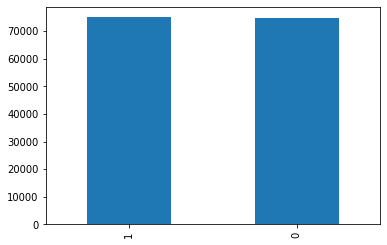

In [18]:
train_data['label'].value_counts().plot(kind='bar')

In [19]:
print(train_data.groupby('label').size().reset_index(name='count'))
# 거의 1:1 비율로 가져온 것을 확인할 수 있다.

   label  count
0      0  74918
1      1  75013


## 데이터 정제하기

* 정규 표현식을 활용하여 한글을 제외하고 모두 제거하기
* 빈 샘플이 생겼는지 확인하기

In [24]:
# 경고문 삭제
import warnings
warnings.filterwarnings('ignore')

In [25]:
train_data['reviews'] = train_data['reviews'].str.replace('[^ㄱ-ㅣ가-힣]', '')
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
print('전처리 후 훈련용 샘플의 개수 :', len(train_data))

ratings    0
reviews    0
label      0
dtype: int64
전처리 후 훈련용 샘플의 개수 : 149931


In [26]:
test_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 갯수 : ',len(test_data))

전처리 후 테스트용 샘플의 갯수 :  49923


## 토큰화

In [27]:
mecab = Mecab()

# 불용어
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']


In [28]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [29]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 단어의 길이 분포 확인하기

In [30]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [32]:
# 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어 출력.
# Counter()를 사용하여 각 단어에 대한 빈도수 계산
negative_word_count = Counter(negative_words)
positive_word_count = Counter(positive_words)

print('부정리뷰 상위 20개')
print(negative_word_count.most_common(20))
print()
print('긍정리뷰 상위 20개')
print(positive_word_count.most_common(20))

부정리뷰 상위 20개
[('네요', 29687), ('는데', 19748), ('안', 18779), ('어요', 13799), ('있', 12927), ('너무', 12576), ('했', 11492), ('좋', 9463), ('배송', 9452), ('어', 8929), ('같', 8631), ('구매', 8540), ('거', 8379), ('없', 8264), ('습니다', 8209), ('되', 8130), ('아요', 8054), ('그냥', 7927), ('않', 7757), ('잘', 7576)]

긍정리뷰 상위 20개
[('좋', 38612), ('아요', 20203), ('네요', 18965), ('잘', 18036), ('어요', 17891), ('구매', 15799), ('습니다', 13113), ('있', 12211), ('배송', 11939), ('는데', 11436), ('했', 9645), ('합니다', 9553), ('먹', 9457), ('재', 9064), ('너무', 8148), ('같', 7640), ('만족', 7071), ('어', 6628), ('아', 6531), ('거', 6261)]


긍정 리뷰의 평균 길이 : 13.229400237292202
부정 리뷰의 평균 길이 : 16.35456098667877


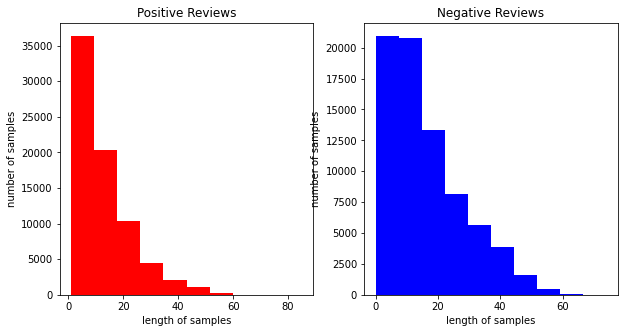

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

text_len1 = train_data[train_data.label == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len1, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')

text_len2 = train_data[train_data.label == 0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len2, color='blue')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')

print('긍정 리뷰의 평균 길이 :', np.mean(text_len1))
print('부정 리뷰의 평균 길이 :', np.mean(text_len2))

# 부정 리뷰의 길이가 좀더 길군...

In [36]:
x_train = train_data['tokenized'].values
y_train = train_data['label'].values
x_test = test_data['tokenized'].values
y_test = test_data['label'].values

## 정수 인코딩

In [37]:
t = Tokenizer()
t.fit_on_texts(x_train)

In [39]:
threshold = 2
total_cnt = len(t.word_index)   # 단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어의 빈도수의 쌍을 key와 value로 받는다.
for key, value in t.word_counts.items():
    total_freq += value

    if (value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold}번 이하인 희귀 단어의 수 :', rare_cnt)
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt/total_cnt)*100, '%')
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq/total_freq)*100, '%')

단어 집합(vocabulary)의 크기 : 51331
등장 빈도가 2번 이하인 희귀 단어의 수 : 27839
단어 집합에서 희귀 단어의 비율 : 54.23428337651711 %
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.255350311233444 %


In [40]:
# 전체 단어 갯수 중 빈도수 2 이하인 단어 개수는 제거
# 0번 패딩 토큰과 1번 OOV 토큰을 고려해서 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 23494


In [41]:
original_vocab_size = vocab_size + rare_cnt - 2
print('기존의 단어집합 크기 :', original_vocab_size)

기존의 단어집합 크기 : 51331


In [42]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [43]:
print(x_train[:3])
print(x_test[:3])

[[64, 2081, 296, 14978, 257, 71, 6, 243, 163, 134, 783, 3060, 626, 2, 1], [457, 408, 50, 8676, 25, 1], [43, 24, 837, 111, 36, 2439, 179, 7, 10, 8171, 4, 1257, 29, 137, 320, 44, 58, 179, 137, 7, 1913, 1996, 109, 162, 1414, 330, 121, 135]]
[[14, 690, 749, 112, 187, 246, 12], [334, 3869, 62, 4182, 1633], [11, 68, 2, 48, 156, 3, 27, 15, 6, 555, 285, 16, 90, 108, 589, 58, 7, 2]]


# 패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 14.790990522306927


Text(0, 0.5, 'number of sample')

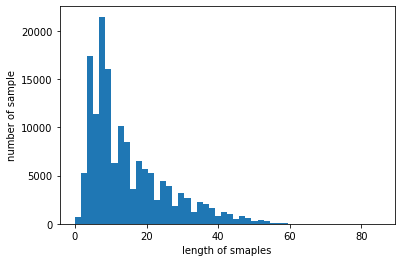

In [44]:
print('리뷰의 최대 길이 :', max(len(l) for l in x_train))
print('리뷰의 평균 길이 :', sum(map(len, x_train)) / len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of smaples')
plt.ylabel('number of sample')

In [45]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt += 1
    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율 : {cnt/len(nested_list) * 100} %')

In [46]:
max_len = 80
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율 : 99.99933302652553 %


In [47]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

print(x_train.shape)
print(x_test.shape)

(149931, 80)
(49923, 80)


## GRU 모델로 학습하기

In [63]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [64]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [65]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mo = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [66]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=30, callbacks=[es, mo], batch_size=60, validation_split=0.2)

Epoch 1/30
2000/2000 [==============================] - 62s 30ms/step - loss: 0.2815 - acc: 0.8900 - val_loss: 0.2375 - val_acc: 0.9117

Epoch 00001: val_acc improved from -inf to 0.91170, saving model to best_model.h5
Epoch 2/30
2000/2000 [==============================] - 59s 29ms/step - loss: 0.2051 - acc: 0.9243 - val_loss: 0.2296 - val_acc: 0.9132

Epoch 00002: val_acc improved from 0.91170 to 0.91323, saving model to best_model.h5
Epoch 3/30
2000/2000 [==============================] - 58s 29ms/step - loss: 0.1685 - acc: 0.9376 - val_loss: 0.2412 - val_acc: 0.9117

Epoch 00003: val_acc did not improve from 0.91323
Epoch 4/30
2000/2000 [==============================] - 57s 29ms/step - loss: 0.1411 - acc: 0.9480 - val_loss: 0.2640 - val_acc: 0.9071

Epoch 00004: val_acc did not improve from 0.91323
Epoch 5/30
2000/2000 [==============================] - 58s 29ms/step - loss: 0.1172 - acc: 0.9567 - val_loss: 0.2984 - val_acc: 0.9053

Epoch 00005: val_acc did not improve from 0.9132

In [67]:
# 저장된 모델 불러오기
loaded_model = load_model('best_model.h5')
# loaded_model = model
print(f'\n 테스트 정확도 : {loaded_model.evaluate(x_test, y_test)[1]:.4f}')

1561/1561 [==============================] - 6s 4ms/step - loss: 0.2226 - acc: 0.9200

 테스트 정확도 : 0.9200


## 리뷰 예측하기

In [70]:
def sentiment_predict(new_sentence):
    # 토큰화 및 불용어 제거
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]

    # 인코딩, 패딩
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen=max_len)

    # 예측
    score = float(loaded_model.predict(pad_new))

    if (score > 0.5):
        print(f'{score*100:.2f} % 확률로 긍정 리뷰입니다.')
    else:
        print(f'{(1-score)*100:.2f} % 확률로 부정 리뷰입니다.')

In [72]:
sentiment_predict('이 상품 진짜 좋아요')
sentiment_predict('이거 별로인데')
sentiment_predict('사지 마셈')
sentiment_predict('완전 좋아요 별점 무조건 5개 드립니다')

96.05 % 확률로 긍정 리뷰입니다.
96.84 % 확률로 부정 리뷰입니다.
57.41 % 확률로 부정 리뷰입니다.
95.53 % 확률로 긍정 리뷰입니다.


# 글자 단위(Character-level)로 구현한 seq2seq 번역기

In [73]:
! wget -NP ./ https://raw.githubusercontent.com/MarigoldJ/ygl2/main/%ED%95%99%EC%8A%B5%EC%9E%90%EB%A3%8C/NLP/dataset/fra.txt

--2021-06-17 07:33:00--  https://raw.githubusercontent.com/MarigoldJ/ygl2/main/%ED%95%99%EC%8A%B5%EC%9E%90%EB%A3%8C/NLP/dataset/fra.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28543409 (27M) [text/plain]
Saving to: ‘./fra.txt’

fra.txt             100%[===================>]  27.22M  88.6MB/s    in 0.3s    

Last-modified header missing -- time-stamps turned off.
2021-06-17 07:33:02 (88.6 MB/s) - ‘./fra.txt’ saved [28543409/28543409]



In [85]:
import os
import pandas as pd
file_path = './fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
lines.sample(5)

,eng,fra,cc
89847,Everyone is trying his best.,Chacun fait de son mieux.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
87906,We were ordered to do that.,On nous a ordonné de faire ça.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
177544,"Whether rains or not, the game is going to be ...","Saison des pluies ou pas, la partie aura lieu.",CC-BY 2.0 (France) Attribution: tatoeba.org #6...
76337,I know you're not serious.,Je sais que vous n'êtes pas sérieuse.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
180878,It was such a wonderful movie that I saw it fi...,C'était un film tellement merveilleux que je l...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [87]:
lines = lines[['eng', 'fra']][:50000]   # 5만개 샘플 사용
lines.sample(5)

,eng,fra
27003,You're productive.,Vous êtes productif.
14287,I'm not unhappy.,Je ne suis pas malheureux.
34885,I must get it fixed.,Je dois le faire réparer.
1606,Answer Tom.,Répondez à Tom.
5193,I've decided.,J'ai décidé.


In [88]:
# 시작 토근과 종료 토근 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x: '\t' + x + '\n')
print('전체 샘플의 수 :', len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
48134,"I really like it, too.",\tJe l'aime également beaucoup.\n
30707,That's one of them.,\tIl s'agit de l'une des leurs.\n
33460,Do you want to talk?,\tVoulez-vous parler ?\n
36289,Our allies are weak.,\tNos alliées sont faibles.\n
32837,You're so paranoid.,\tTu es tellement paranoïaque !\n


In [89]:
# 영어 토큰화
eng_tokenizer = Tokenizer(char_level=True)
# 글자 단위로 토큰화
eng_tokenizer.fit_on_texts(lines.eng)
# 5만개 행을 가진 eng의 각 행에 토큰화 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
# 단어를 숫자값 인덱스로 변환하여 저장
print(input_text[:3])

# 프랑스어 토큰화
fra_tokenizer = Tokenizer(char_level=True)
# 글자 단위로 토큰화
fra_tokenizer.fit_on_texts(lines.fra)
# 5만개 행을 가진 eng의 각 행에 토큰화 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)
# 단어를 숫자값 인덱스로 변환하여 저장
print(target_text[:3])

[[19, 3, 8], [19, 3, 8], [19, 3, 8]]
[[10, 19, 5, 1, 31, 11], [10, 15, 5, 12, 16, 29, 2, 14, 11], [10, 26, 9, 8, 28, 2, 1, 31, 11]]


In [90]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73


In [91]:
max_eng_seq_len = max([len(l) for l in input_text])
max_fra_seq_len = max([len(l) for l in target_text])

print('영어 시퀀스의 최대 길이 :', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이 :', max_fra_seq_len)

영어 시퀀스의 최대 길이 : 22
프랑스어 시퀀스의 최대 길이 : 74


In [92]:
# 정리
print('전체 샘플의 수 :', len(lines))
print()
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print()
print('영어 시퀀스의 최대 길이 :', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이 :', max_fra_seq_len)

전체 샘플의 수 : 50000

영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73

영어 시퀀스의 최대 길이 : 22
프랑스어 시퀀스의 최대 길이 : 74


In [94]:
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index[eos_token]] for line in target_text]
# 시작 토큰 제거
decoder_target = [[char for char in line if char != fra_tokenizer.word_index[sos_token]] for line in target_text]

print(decoder_input[:3])    # <eos> 토큰 제거
print(decoder_target[:3])   # <sos> 토큰 제거


[[10, 19, 5, 1, 31], [10, 15, 5, 12, 16, 29, 2, 14], [10, 26, 9, 8, 28, 2, 1, 31]]
[[19, 5, 1, 31, 11], [15, 5, 12, 16, 29, 2, 14, 11], [26, 9, 8, 28, 2, 1, 31, 11]]


In [95]:
encoder_input = pad_sequences(encoder_input, maxlen=max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_seq_len, padding='post')

print('영어 데이터의 크기(shape) :', np.shape(encoder_input))
print('프랑스어 입력데이터의 크기 :', np.shape(decoder_input))
print('프랑스어 출력데이터의 크기 :', np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 22)
프랑스어 입력데이터의 크기 : (50000, 74)
프랑스어 출력데이터의 크기 : (50000, 74)


In [96]:
print(encoder_input[0])

[19  3  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [97]:
# one-hot encoding
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

print('영어 데이터의 크기(shape) :', np.shape(encoder_input))
print('프랑스어 입력데이터의 크기 :', np.shape(decoder_input))
print('프랑스어 출력데이터의 크기 :', np.shape(decoder_target))
# (샘플의 수, 샘플의 길이, 단어장의 크기)

영어 데이터의 크기(shape) : (50000, 22, 52)
프랑스어 입력데이터의 크기 : (50000, 74, 73)
프랑스어 출력데이터의 크기 : (50000, 74, 73)


In [98]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습 데이터의 크기 :', np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기 :', np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기 :', np.shape(decoder_target_train))


영어 학습 데이터의 크기 : (47000, 22, 52)
프랑스어 학습 입력데이터의 크기 : (47000, 74, 73)
프랑스어 학습 출력데이터의 크기 : (47000, 74, 73)


## 모델 훈련하기

In [100]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [102]:
# LSTM 셀의 마지막 time stem의 hidden state와 cell state를
# 디코더 LSTM의 첫번째 hidden state와 cell state로 전달해주자

encoder_inputs = Input(shape=(None, eng_vocab_size))    # 입력 텐서 생성
encoder_lstm = LSTM(units=256, return_state=True)       # hidden state 256인 LSTM 생성
_, state_h, state_c = encoder_lstm(encoder_inputs)      # 디코더로 전달할 state들을 반환 (encoder_output은 이때 불필요)
encoder_states = [state_h, state_c]                     # 전달할 state를 별도로 저장

decoder_inputs = Input(shape=(None, fra_vocab_size))                                    # 입력 텐서 생성
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)                # hidden state size 256 디코더 LSTM 생성
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)      # decoder output은 모든 timestep의 hidden state


In [103]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [104]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 52)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 316416      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  337920      input_3[0][0]                    
                                                                 lstm_1[0][1]                 

In [105]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=30)

Epoch 1/30
368/368 [==============================] - 9s 17ms/step - loss: 0.9052 - val_loss: 0.7943
Epoch 2/30
368/368 [==============================] - 6s 16ms/step - loss: 0.5621 - val_loss: 0.6450
Epoch 3/30
368/368 [==============================] - 6s 15ms/step - loss: 0.4612 - val_loss: 0.5635
Epoch 4/30
368/368 [==============================] - 6s 15ms/step - loss: 0.4053 - val_loss: 0.5134
Epoch 5/30
368/368 [==============================] - 6s 15ms/step - loss: 0.3686 - val_loss: 0.4713
Epoch 6/30
368/368 [==============================] - 6s 15ms/step - loss: 0.3414 - val_loss: 0.4589
Epoch 7/30
368/368 [==============================] - 6s 16ms/step - loss: 0.3201 - val_loss: 0.4298
Epoch 8/30
368/368 [==============================] - 6s 16ms/step - loss: 0.3030 - val_loss: 0.4151
Epoch 9/30
368/368 [==============================] - 6s 16ms/step - loss: 0.2890 - val_loss: 0.4088
Epoch 10/30
368/368 [==============================] - 6s 15ms/step - loss: 0.2774 - val_lo

## 모델 테스트

* 훈련시에 학습해야할 타겟 문장을 디코더 모델의 입력, 출력 시퀀스로 넣어주고, 디코더 모델이 타겟문장을 한꺼번에 출력하게 할 수 있습니다.
* 그러나 테스트 단계는 불가능!

* 테스트 단계에서 디코더 동작 순서
    1. 인코더에 입력 문장을 넣어 마지막 time step의 hidden, cell state를 얻는다.
    2. 토큰인 \t를 디코더에 입력한다.
    3. 이전 timestep의 출력층의 예측결과를 현재 timestep의 입력으로 한다.
    4. 3을 반복하다가 토큰인 \n가 예측되면 이를 중단한다.

In [106]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 52)]        0         
_________________________________________________________________
lstm_1 (LSTM)                [(None, 256), (None, 256) 316416    
Total params: 316,416
Trainable params: 316,416
Non-trainable params: 0
_________________________________________________________________


In [108]:
# 이전 timestep
decoder_state_input_h = Input(shape=(256,))     # 이전 timestep의 hidden state
decoder_state_input_c = Input(shape=(256,))     # 이전 timestep의 cell state
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]   # 이전 timestep의 state들 저장

# 현재 timestep
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs) # 이전 state를 현재 timestep의 state로 사용
decoder_states = [state_h, state_c]             # 현재 timestep의 state를 저장


In [109]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model= Model(inputs=[decoder_inputs] + decoder_state_inputs, outputs=[decoder_outputs]+decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  337920      input_3[0][0]                    
                                                                 input_6[0][0]              

In [110]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [112]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 이전 timestep의 상태 state_value를 현재 timestep의 초기 state로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 index -> fra 로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 timestep의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == '\n') or (len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True
        
        # 현재 timestep의 예측 결과를 다음 timestep의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1

        # 현재 timestep의 state를 다음 timestep의 state로 사용하기 위해 저장
        states_value = [h, c]
    
    return decoded_sentence

In [114]:
import numpy as np
for seq_index in [3, 50, 100, 300, 1001]:
    # 입력 문장의 인덱스 (자유롭게 바꿔서 출력해 보세요)
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)

    print('-' * 40)
    print('입력 문장 :', lines.eng[seq_index])
    print('정답 문장 :', lines.fra[seq_index][1:len(lines.fra[seq_index]) - 1])
    print('번역기가 번역한 문장 :', decoded_sentence[:len(decoded_sentence) - 1])


----------------------------------------
입력 문장 : Hi.
정답 문장 : Salut !
번역기가 번역한 문장 : salut !
----------------------------------------
입력 문장 : I won!
정답 문장 : Je l'ai emporté !
번역기가 번역한 문장 : j'ai appelé !
----------------------------------------
입력 문장 : I fled.
정답 문장 : J'ai fui.
번역기가 번역한 문장 : j'ai oublié.
----------------------------------------
입력 문장 : Hug Tom.
정답 문장 : Fais un câlin à Tom.
번역기가 번역한 문장 : salutez !
----------------------------------------
입력 문장 : I give in.
정답 문장 : Je donne ma langue au chat.
번역기가 번역한 문장 : je me suis rendu.
